# **DETECCIÓN DE CRÁTERES EN MARTE Y LA LUNA** (CONSTRUIR UN MODELO DE DETECCIÓN DE OBJETOS)

**(A) HACER FUNCIONAR EL CÓDIGO CON LOS DATOS DADOS**

**Parte 1.Introducción y Montaje**

Importar los datos

In [1]:
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python

!mkdir ./train
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/labels/. ./train/labels/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/labels/. ./train/labels/

Cloning into 'vision'...
remote: Enumerating objects: 424635, done.
remote: Counting objects: 100% (5097/5097), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 424635 (delta 4790), reused 5049 (delta 4764), pack-reused 419538
Receiving objects: 100% (424635/424635), 836.56 MiB | 25.70 MiB/s, done.
Resolving deltas: 100% (393870/393870), done.
fatal: not a git repository (or any of the parent directories): .git
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-jt00xvuo
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-jt00xvuo
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375460 sha256=5247cb22097a156f76a7098e8b524a15ba89a57d8823d6fdb065ca2b7aa3b2cd
  Stored in directory: /tmp/pip-ephe

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hrHgANwgC8VyXLhXgxLYHTrILpeJ5bLl
!unzip /content/mars_and_moon.zip

Downloading...
From: https://drive.google.com/uc?id=1hrHgANwgC8VyXLhXgxLYHTrILpeJ5bLl
To: /content/mars_and_moon.zip
100% 77.6M/77.6M [00:00<00:00, 104MB/s]
Archive:  /content/mars_and_moon.zip
  inflating: best.pt                 
  inflating: craters/test/images/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg  
  inflating: craters/test/images/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg  
  inflating: craters/test/images/019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg  
  inflating: craters/test/images/04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg  
  inflating: craters/test/images/mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg  
  inflating: craters/test/images/mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg  
  inflating: craters/test/images/mars_crater--116-_jpg.rf.2e550a693a8800808e68848484716b95.jpg  
  inflating: craters/test/images/mars_crater--117-_jpg.rf.b412b6593d102c5f9dda7bce79bb815c.jpg  
  inflating: craters/test/images/mars_crater--12-

Importar las librerias

In [3]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

Este código establece las bibliotecas necesarias para entrenar un modelo de detección de objetos utilizando la red convolucional Faster R-CNN. También se prepara para dividir los datos utilizando K-Fold cross-validation y se inicia una salida de imágenes aleatoria para asegurar que la validación es correcta.

**Parte 2. Dataset Class Setup**

Se definen una serie de funciones

In [4]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Crater']

    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

Esta parte del codigo se utiliza para cargar datos de imágenes y sus etiquetas, aplicar transformaciones a nuestros datos y prepararlos para entrenar un modelo de detección de objetos en PyTorch. El código se encarga de la manipulación de datos y su preparación para el entrenamiento posterior del modelo.
El root es el lugar donde se almacenan las imágenes.
Transforms es todo lo que se aplica a las imágenes para cambiarlas.

**Parte 3. Configuración Del Modelo**

In [5]:
def get_model_bbox(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

En esta función se toma un modelo Faster R-CNN y lo adaptamos a nuestros datos, usando el parámetro de num_classes para que sea compatible con nuestro conjunto de datos.

In [6]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

Esta función configura y crea un conjunto de transformaciones que aplicamos a las imágenes antes del entrenamiento o evaluación. Si estamos entrenando o evaluando el modelo, se aplican diferentes tipos de transformaciones para mejorar el rendimiento del modelo.

In [7]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

Esta función se encarga de que cada entrenamiento se restablezca desde 0, es decir que los entrenamientos futuros no dependan de los ya realizados; es decir restablecen los pesos del modelo.

**Parte 4. Visualización de la Imagen**

In [8]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

Esta función se utiliza para visualizar una imagen junto con las cajas delimitadoras (las cajas que encuentran los objetos). Se emplea para comprender visualmente el rendimiento de un modelo de detección de objetos (viendo los resultados de los objetos detectados).

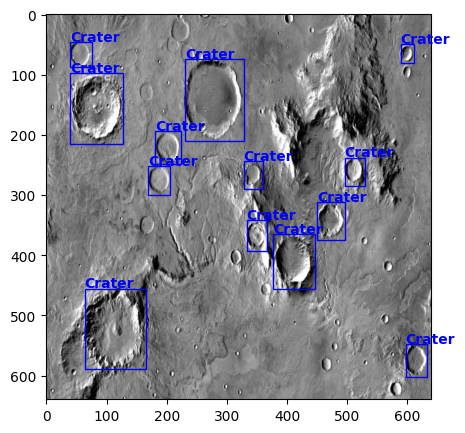

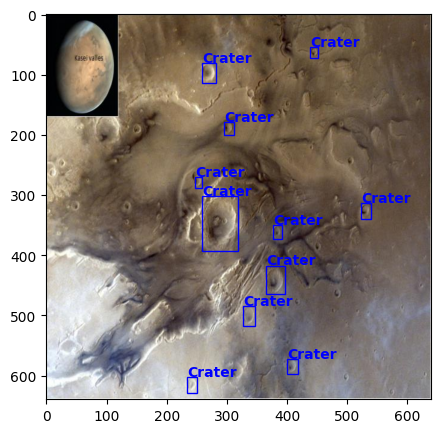

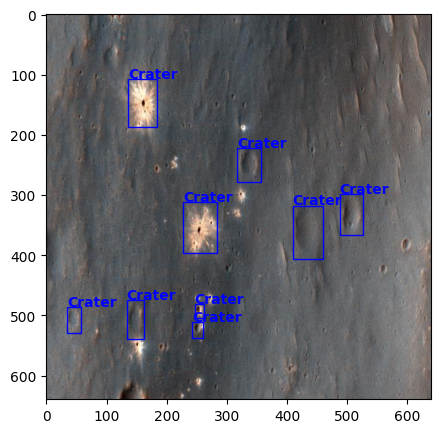

In [9]:
dataset = CraterDataset('craters/train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

Se muestra ejemplos de imágenes con sus respectivas cajas
delimitadoras, conformando que funciona el modelo de detección de objetos. Las imágenes se eligen al azar (random) para proporcionar una representación variada del modelo.

 **Parte 5. K-fold Cross Validation**

Entrenamiento del modelo

In [10]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
k_folds = 2
num_epochs = 3


# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('craters/train', get_transform(train=True))
dataset_val = CraterDataset('craters/train', get_transform(train=False))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)

    #model.apply(reset_weights) # Check if beneficial

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                momentum=0.9, weight_decay=0)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10,
                                                    gamma=0.1)

    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()

--------------------------------
FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 64.8MB/s]


Epoch: [0]  [0/7]  eta: 0:01:48  lr: 0.000838  loss: 2.4179 (2.4179)  loss_classifier: 0.5626 (0.5626)  loss_box_reg: 0.3908 (0.3908)  loss_objectness: 1.3905 (1.3905)  loss_rpn_box_reg: 0.0740 (0.0740)  time: 15.4865  data: 0.8699  max mem: 7206
Epoch: [0]  [6/7]  eta: 0:00:03  lr: 0.005000  loss: 1.1807 (1.2884)  loss_classifier: 0.4208 (0.3986)  loss_box_reg: 0.3893 (0.3508)  loss_objectness: 0.2652 (0.5050)  loss_rpn_box_reg: 0.0219 (0.0340)  time: 3.2752  data: 0.1504  max mem: 7365
Epoch: [0] Total time: 0:00:22 (3.2831 s / it)
Epoch: [1]  [0/7]  eta: 0:00:12  lr: 0.005000  loss: 1.0729 (1.0729)  loss_classifier: 0.5289 (0.5289)  loss_box_reg: 0.4305 (0.4305)  loss_objectness: 0.0616 (0.0616)  loss_rpn_box_reg: 0.0519 (0.0519)  time: 1.8271  data: 0.4119  max mem: 7365
Epoch: [1]  [6/7]  eta: 0:00:01  lr: 0.005000  loss: 0.7982 (0.7781)  loss_classifier: 0.2869 (0.3371)  loss_box_reg: 0.3750 (0.3223)  loss_objectness: 0.0807 (0.0775)  loss_rpn_box_reg: 0.0411 (0.0412)  time: 1.32

Aqui hemos validado el modelo con K-fold cross validation, tuvimos que modificar parte del código debido a que no era necesario. Cambiamos el K-fold a 2, ya que no necesitamos una validación robusta, sino simplemente entender el código; también cambiamos el num_epochs a 3, ya que no necesitamos que el modelo se entrene más veces, sino simplemente las suficientes para que funcione. Por último, quitamos todas las lineas de parámetros de results y evaluation ya que no nos interesa esa parte del código.

**Parte 6. Entrenamiento final y evaluación**

Entrenamiento de todo el conjunto de datos

In [11]:
num_epochs = 3

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('craters/train', get_transform(train=True))
dataset_test = CraterDataset('craters/train', get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_bbox(num_classes)

'''
Use this to reset all trainable weights
model.apply(reset_weights)
'''

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,  # Feel free to play with values
                            momentum=0.9, weight_decay=0)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.2)


result_mAP = []
best_epoch = None

# Let's train!
for epoch in range(num_epochs):


    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [ 0/13]  eta: 0:00:25  lr: 0.000421  loss: 2.6664 (2.6664)  loss_classifier: 0.6337 (0.6337)  loss_box_reg: 0.2720 (0.2720)  loss_objectness: 1.6770 (1.6770)  loss_rpn_box_reg: 0.0837 (0.0837)  time: 1.9267  data: 0.4315  max mem: 7367
Epoch: [0]  [12/13]  eta: 0:00:01  lr: 0.005000  loss: 0.9735 (1.1812)  loss_classifier: 0.3845 (0.4207)  loss_box_reg: 0.3150 (0.3289)  loss_objectness: 0.1586 (0.3859)  loss_rpn_box_reg: 0.0414 (0.0457)  time: 1.5098  data: 0.0758  max mem: 7367
Epoch: [0] Total time: 0:00:19 (1.5187 s / it)
Epoch: [1]  [ 0/13]  eta: 0:00:29  lr: 0.005000  loss: 0.5605 (0.5605)  loss_classifier: 0.2138 (0.2138)  loss_box_reg: 0.2703 (0.2703)  loss_objectness: 0.0554 (0.0554)  loss_rpn_box_reg: 0.0210 (0.0210)  time: 2.2656  data: 0.6600  max mem: 7367
Epoch: [1]  [12/13]  eta: 0:00:01  lr: 0.005000  loss: 0.6702 (0.7096)  loss_classifier: 0.2437 (0.2384)  loss_box_reg: 0.3338 (0.3260)  loss_objectness: 0.0719 (0.0946)  loss_rpn_box_reg: 0.0412 (0.0507)  tim

Por último, aquí realizamos una evaluación final del código (una vez ha sido entrenado y validado) con datos de prueba, para probar su funcionamiento. También hemos modificado los epochs ya que no son necesarios tantos (solo ralentiza el proceso) y hemos suprimido la parte de results ya que es información no relevante.

**(B) MODIFICAR CÓDIGO PARA COMPARAR ALGORITMO**

En los pasos anteriores hemos utilizado el modelo de fasterrcnn_resnet50_fpn. En la siguiente parte de la práctica, vamos a utilizar otro modelo diferente pero con el mismo resultado y asi estableceremos una comparación entre los dos. El modelo elegido va a ser maskrcnn_resnet50_fpn.

**PARTE 2: Elección del modelo**

In [12]:
import torchvision.models.detection as detection_models

# Obtiene una lista de modelos disponibles para la detección de objetos en torchvision
avaliable_models = [name for name in dir(detection_models) if not name.startswith("_")]

# Imprime la lista de modelos disponibles
for model_name in avaliable_models:
    print(model_name)



FCOS
FCOS_ResNet50_FPN_Weights
FasterRCNN
FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
FasterRCNN_MobileNet_V3_Large_FPN_Weights
FasterRCNN_ResNet50_FPN_V2_Weights
FasterRCNN_ResNet50_FPN_Weights
KeypointRCNN
KeypointRCNN_ResNet50_FPN_Weights
MaskRCNN
MaskRCNN_ResNet50_FPN_V2_Weights
MaskRCNN_ResNet50_FPN_Weights
RetinaNet
RetinaNet_ResNet50_FPN_V2_Weights
RetinaNet_ResNet50_FPN_Weights
SSD300_VGG16_Weights
SSDLite320_MobileNet_V3_Large_Weights
anchor_utils
backbone_utils
faster_rcnn
fasterrcnn_mobilenet_v3_large_320_fpn
fasterrcnn_mobilenet_v3_large_fpn
fasterrcnn_resnet50_fpn
fasterrcnn_resnet50_fpn_v2
fcos
fcos_resnet50_fpn
generalized_rcnn
image_list
keypoint_rcnn
keypointrcnn_resnet50_fpn
mask_rcnn
maskrcnn_resnet50_fpn
maskrcnn_resnet50_fpn_v2
retinanet
retinanet_resnet50_fpn
retinanet_resnet50_fpn_v2
roi_heads
rpn
ssd
ssd300_vgg16
ssdlite
ssdlite320_mobilenet_v3_large
transform


**PARTE 3: Configuración con del modelo**


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import utils
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


In [ ]:
# Usamos el modelo maskrcnn_resnet50_fpn para realizar el código
def get_model_bbox_alternativo(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



In [ ]:
# Define la transformación de datos
def get_transform(train):
    if train:
        return A.Compose([
            A.Flip(p=0.5),
            A.RandomResizedCrop(height=640, width=640, p=0.4),
            A.Rotate(p=0.5),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [ ]:
# Define la función para resetear los pesos del modelo
def reset_weights_alternativo(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()


Aqui hemos realizado todo el código anterior, pero cambiando el modelo al maskrcnn_resnet50_fpn.

**PARTE 4: Visualización de la imagen**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    ax.imshow(img.permute(1, 2, 0))

    for box, label in zip(target['boxes'], target['labels']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y), width, height, edgecolor='b', facecolor='none', clip_on=False)
        ax.add_patch(rect)

        ax.annotate(f'Class: {label.item()}', (x, y - 5), color='blue', fontsize=10, ha='left', va='top')

    plt.show()



In [ ]:
def train_model(model, optimizer, data_loader, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}')

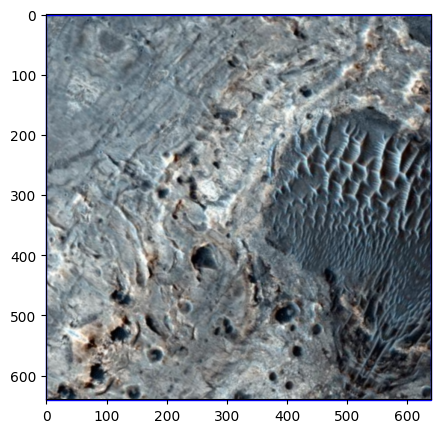

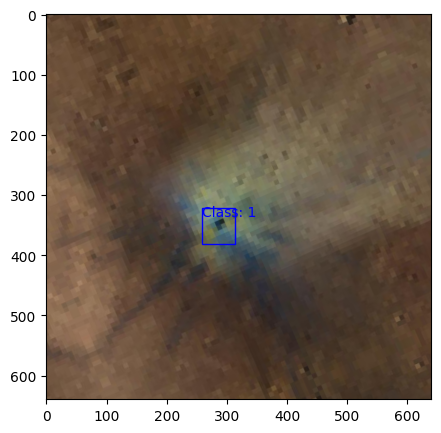

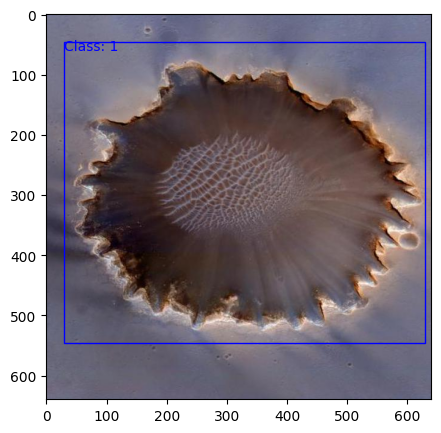

In [ ]:
dataset = CraterDataset('craters/train', get_transform(train=True))

# Imprime un ejemplo de imagen con anotaciones para 3 imágenes aleatorias
for i in random.sample(range(len(dataset)), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)



Aquí podemos observar que el modelo funciona. La mejora principal del modelo Mask R-CNN en comparación con Faster R-CNN radica en su capacidad adicional para realizar segmentación de instancias. Esta mejora permite que Mask R-CNN no solo detecte y localice objetos en una imagen, sino que también genere máscaras precisas que delinean la forma exacta de cada objeto a nivel de píxeles.
Faster R-CNN es un modelo más ligero en comparación con Mask R-CNN, ya que no tiene la sobrecarga adicional de generar máscaras de segmentación.

En resumen, para tareas de detección de objetos estándar donde solo necesitas las coordenadas de las cajas delimitadoras que rodean a los objetos, Faster R-CNN puede ser una elección más eficiente y rápida.

**(C) Entrenar el nuevo modelo para que haga las predicciones en verde**

**PARTE 5: Entrenamiento del modelo**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Configuración de k-folds y número de épocas
k_folds = 4
num_epochs = 10
num_classes = 2

# Conjunto de datos y transformaciones
dataset = CraterDataset('craters/train', get_transform(train=True))
dataset_val = CraterDataset('craters/train', get_transform(train=False))

# K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # DataLoaders
    data_loader = torch.utils.data.DataLoader(
        dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # Modelo
    model = get_model_bbox_alternativo(num_classes)
    model.to(device)

    # Optimizador y programador de tasa de aprendizaje
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Entrenamiento
    train_model(model, optimizer, data_loader, device, num_epochs=num_epochs)


--------------------------------
FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: ignored

Aquí hemos empleado el código para realizar un buen entreamiento del modelo, que consta de 10 epochs. Hemos creado dos dataloaders, uno para el conjunto de entrenamiento y otro para el conjunto de validación. Los dataloaders se encargan de cargar lotes de datos de forma eficiente y aplicar la función collate_fn para formatear los datos. El entrenamiento no ha sido efectivo, ya que con este modelo se necesitan crear máscaras para cada uno de los datos y no es posible, por tanto vamos a utilizar otro modelo.

**B) CREACIÓN DEL MODELO FINAL**

In [30]:
import os #Biblioteca con funciones para interactuar con el sistema operativo, como trabajar con rutas de archivos y directorios.
import numpy as np #Biblioteca para cálculos numéricos: análisis de datos y manipulación de matrices.
import torch #PyTorch: construir y entrenar modelos de aprendizaje profundo.
import torchvision #Biblioteca que forma parte de PyTorch y proporciona modelos preentrenados y utilidades para la visión por computadora.
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn #Módulo específico de TorchVision que se utiliza para definir el predictor de la capa de detección de objetos Faster R-CNN.
from engine import train_one_epoch, evaluate
import utils
import transforms as T #Transformaciones de datos utilizadas durante el entrenamiento y la evaluación.
import albumentations as A #Biblioteca que se utiliza para aplicar transformaciones de datos, como aumentaciones, a imágenes y etiquetas de detección de objetos.
import cv2 #OpenCV: biblioteca de visión por computadora que se utiliza para trabajar con imágenes y aplicar diversas operaciones de procesamiento de imágenes.
import time #Esta biblioteca proporciona funciones relacionadas con la medición del tiempo y se utiliza para calcular el tiempo que lleva ejecutar ciertas operaciones.
from albumentations.pytorch.transforms import ToTensorV2 #Importa una transformación de Albumentations que convierte las imágenes en tensores de PyTorch.
import matplotlib #Biblioteca para crear gráficos y visualizaciones
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random #Esta biblioteca proporciona funciones relacionadas con la generación de números aleatorios y se utiliza para realizar selecciones aleatorias, como la selección de muestras de datos durante el entrenamiento cruzado (K-fold).

In [40]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Crater']

    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

Con este código lo que hago es definir mis datos; es decir me proporciona imágenes y sus respectivas cajas delimitadoras y etiquetas. Estos datos se utilizan para entrenar o evaluar el modelo RetinaNet, que es un modelo de detección de objetos basado en redes neuronales convolucionales complejo.



**Creación del modelo RetinaNet**

In [32]:
# Usamos el modelo retinanet_resnet50_fpn para realizar el código
def get_model_alternativo(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes, pretrained=True)
    return model


In [41]:
# Define la transformación de datos
def get_transform_alternativo(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [42]:
# Define la función para resetear los pesos del modelo
def reset_weights_alternativo(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

**Visualizamos las imágenes del modelo**

In [35]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

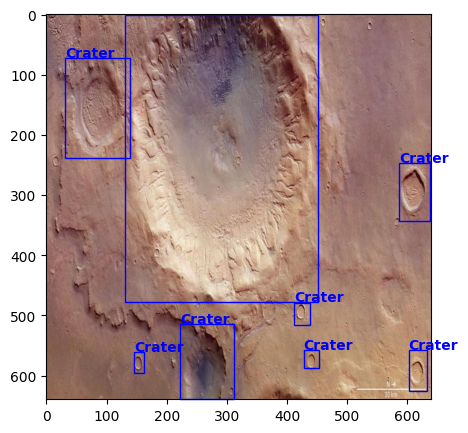

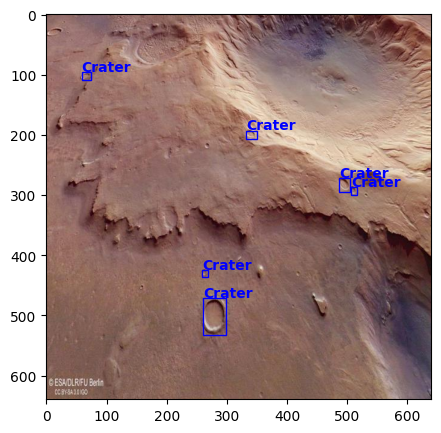

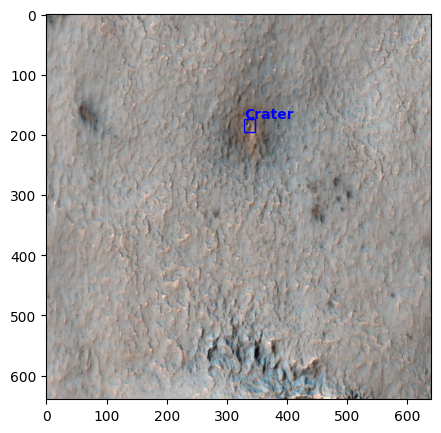

In [36]:
dataset = CraterDataset('craters/train', get_transform_alternativo(train=True))

# Imprime un ejemplo de imagen con anotaciones para 3 imágenes aleatorias
for i in random.sample(range(len(dataset)), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

**C) ENTRENAMIENTO Y CAJAS DELIMITADORAS EN VERDE DEL MODELO FINAL**

**PARTE 5: Entrenamiento y validación**

In [44]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
k_folds = 3
num_epochs = 10


# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('craters/train', get_transform_alternativo(train=True))
dataset_val = CraterDataset('craters/train', get_transform_alternativo(train=False))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_alternativo(num_classes)

    #model.apply(reset_weights) # Check if beneficial

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,  # Cambiamos la learning rate para que el modelo no diverja
                                momentum=0.9, weight_decay=0)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10,
                                                    gamma=0.1)

    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()

--------------------------------
FOLD 0
--------------------------------
Epoch: [0]  [0/9]  eta: 0:00:21  lr: 0.000126  loss: 1.8423 (1.8423)  classification: 1.4381 (1.4381)  bbox_regression: 0.4042 (0.4042)  time: 2.4180  data: 0.5236  max mem: 11872
Epoch: [0]  [8/9]  eta: 0:00:01  lr: 0.001000  loss: 1.4176 (1.4167)  classification: 1.0567 (1.0274)  bbox_regression: 0.3896 (0.3894)  time: 1.7168  data: 0.0875  max mem: 11872
Epoch: [0] Total time: 0:00:15 (1.7318 s / it)
Epoch: [1]  [0/9]  eta: 0:00:23  lr: 0.001000  loss: 0.9357 (0.9357)  classification: 0.6536 (0.6536)  bbox_regression: 0.2821 (0.2821)  time: 2.6424  data: 0.8163  max mem: 11872
Epoch: [1]  [8/9]  eta: 0:00:01  lr: 0.001000  loss: 0.8546 (0.8212)  classification: 0.5218 (0.5125)  bbox_regression: 0.3161 (0.3086)  time: 1.7134  data: 0.1192  max mem: 11872
Epoch: [1] Total time: 0:00:15 (1.7306 s / it)
Epoch: [2]  [0/9]  eta: 0:00:20  lr: 0.001000  loss: 0.6965 (0.6965)  classification: 0.4280 (0.4280)  bbox_regre

Aqui hemos entrenado el modelo RetinaNet en un entorno de validación cruzada. A medida que se ejecuta, el modelo se entrena para cada fold, y la tasa de aprendizaje se ajusta según el programador de tasa de aprendizaje.

La principal diferencia entre RetinaNet y Faster R-CNN radica en su arquitectura y enfoque de diseño. Mientras que Faster R-CNN utiliza una arquitectura de dos etapas con un Region Proposal Network (RPN) para generar propuestas de región y una etapa de clasificación y regresión para la detección final, RetinaNet opta por una arquitectura de una sola etapa con Feature Pyramid Network (FPN) para manejar objetos de diferentes escalas. La clave distintiva de RetinaNet es la introducción de Focal Loss en su módulo de predicción, abordando así el desafío del desequilibrio de clases al asignar mayor peso a los ejemplos difíciles, lo que mejora su capacidad para detectar objetos pequeños y difíciles en imágenes. En resumen, RetinaNet ofrece una solución más eficaz y simplificada para la detección de objetos en comparación con la estructura de dos etapas de Faster R-CNN.

**PARTE 6: Entrenamiento final**

In [45]:
num_epochs = 20

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('craters/train', get_transform_alternativo(train=True))
dataset_test = CraterDataset('craters/test', get_transform_alternativo(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_alternativo(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,  # Feel free to play with values
                            momentum=0.9, weight_decay=0)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.2)


result_mAP = []
best_epoch = None

# Let's train!
for epoch in range(num_epochs):


    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()


Epoch: [0]  [ 0/13]  eta: 0:00:34  lr: 0.000084  loss: 1.6317 (1.6317)  classification: 1.2481 (1.2481)  bbox_regression: 0.3836 (0.3836)  time: 2.6603  data: 0.8498  max mem: 11872
Epoch: [0]  [12/13]  eta: 0:00:01  lr: 0.001000  loss: 1.2622 (1.3905)  classification: 0.9069 (1.0031)  bbox_regression: 0.3807 (0.3874)  time: 1.7659  data: 0.0973  max mem: 11872
Epoch: [0] Total time: 0:00:23 (1.7729 s / it)
Epoch: [1]  [ 0/13]  eta: 0:00:30  lr: 0.001000  loss: 1.0130 (1.0130)  classification: 0.6736 (0.6736)  bbox_regression: 0.3394 (0.3394)  time: 2.3294  data: 0.5129  max mem: 11872
Epoch: [1]  [12/13]  eta: 0:00:01  lr: 0.001000  loss: 0.9290 (0.9387)  classification: 0.5619 (0.6089)  bbox_regression: 0.3394 (0.3298)  time: 1.7643  data: 0.0720  max mem: 11872
Epoch: [1] Total time: 0:00:23 (1.7719 s / it)
Epoch: [2]  [ 0/13]  eta: 0:00:28  lr: 0.001000  loss: 0.7357 (0.7357)  classification: 0.5227 (0.5227)  bbox_regression: 0.2130 (0.2130)  time: 2.2264  data: 0.4478  max mem: 11

Aquí realizamos un segundo entrenamiento o entrenamiento alternativo, con 20 epochs para asegurarnos de que el modelo funciona correctamente, antes de pasar a visualizar las imágenes.

**Parte 7: Visualizar imágenes en verde**

In [46]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='g',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='green', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

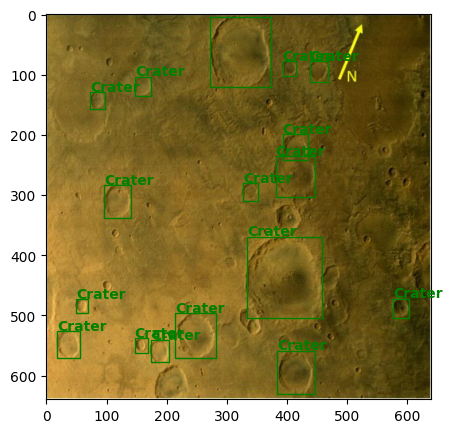

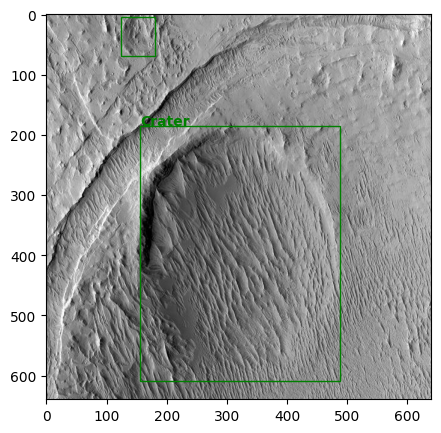

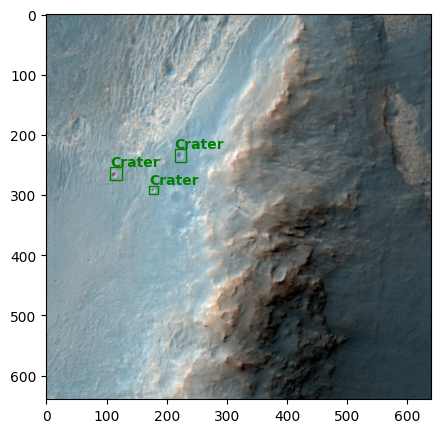

In [47]:
dataset = CraterDataset('craters/train', get_transform_alternativo(train=True))

# Imprime un ejemplo de imagen con anotaciones para 3 imágenes aleatorias
for i in random.sample(range(len(dataset)), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

Esta parte del código te permite seleccionar un número de imágenes al azar de tu conjunto de datos y visualizar esas imágenes junto con sus cajas delimitadoras en verde para evaluar cómo el modelo de detección de objetos está funcionando en una muestra aleatoria de imágenes.

Por tanto, concluimos con que el modelo RetinaNet funciona correctamente y está perfectamente entrenado.